<a href="https://colab.research.google.com/github/valeranzo1/Modelli-della-Percezione/blob/main/Tumor_Classification_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Collegamento al dataset caricato su Google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Classi di destinazione

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0 - Tumor
# 1 - Normal

In [7]:
# Questa cella aggiorna l'elenco dei risultati per le immagini con tumore
data = []
paths = []
result = []

for r, d, f in os.walk(r"/content/drive/MyDrive/Modelli_della_Percezione/Dataset/brain_tumor_dataset/yes"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

# Creare elenchi


1. elenco di dati per memorizzare i dati delle immagini in forma di array numpy
2. elenco dei percorsi per memorizzare i percorsi di tutte le immagini
3. elenco di risultati per memorizzare una forma codificata a caldo della classe di destinazione, normale o tumorale

In [8]:
# Questa cella aggiorna l'elenco dei risultati per le immagini senza tumore

paths = []
for r, d, f in os.walk(r"/content/drive/MyDrive/Modelli_della_Percezione/Dataset/brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [9]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [10]:
result = np.array(result)
result = result.reshape(139,2)

# Suddivisione dei dati in Training e Testing

In [11]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

# Modello di costruzione

Usiamo la Batch Normalization nell'addestramento per standardizzare gli ingressi di ogni strato all'interno di un mini-batch.

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.regularizers import l2

model = Sequential()

# Definisci il layer di input separatamente
model.add(Input(shape=(128, 128, 3)))

# Primo strato convoluzionale con regolarizzazione L2
model.add(Conv2D(32, kernel_size=(2, 2), padding='Same', kernel_regularizer=l2(0.01)))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='Same', kernel_regularizer=l2(0.01)))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Secondo blocco convoluzionale con L2
model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='Same', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='Same', kernel_regularizer=l2(0.01)))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Flatten e strati densi con L2
model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))  # L2 aggiunto
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.01)))  # Anche sul layer finale

# Compilazione del modello
model.compile(loss="categorical_crossentropy", optimizer='Adamax')

print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,585,602 (128.12 MB)

 Trainable params: 33,585,410 (128.12 MB)

 Non-trainable params: 192 (768.00 B)

None


In [13]:
y_train.shape

(111, 2)

In [14]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 32.4612 - val_loss: 24.0676
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 20.3108 - val_loss: 24.6931
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 16.8534 - val_loss: 36.5818
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 14.8951 - val_loss: 18.2374
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 13.9480 - val_loss: 16.3134
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 13.2351 - val_loss: 20.3613
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - loss: 12.6346 - val_loss: 18.8625
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 11.7872 - val_loss: 15.0461
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 11.2816 - val_loss: 13.1374
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 11.1430 - val_loss: 12.8972
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 11.1192 - val_loss: 13.2717
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 10.8402 - val_loss:

# Tracciare le perdite

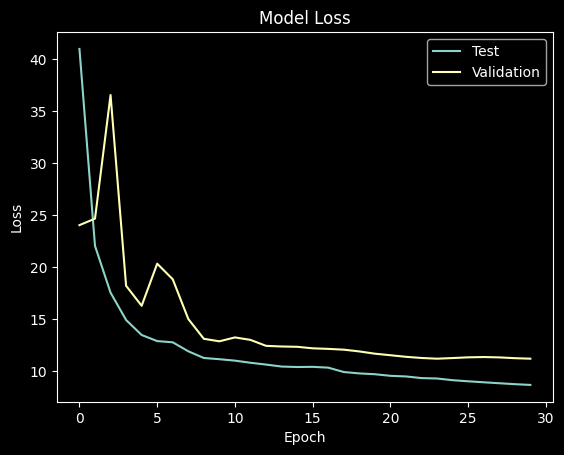

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

# Controlliamo che il modello funzioni

In [16]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

99.99972581863403% Confidence This Is No, Its not a tumor


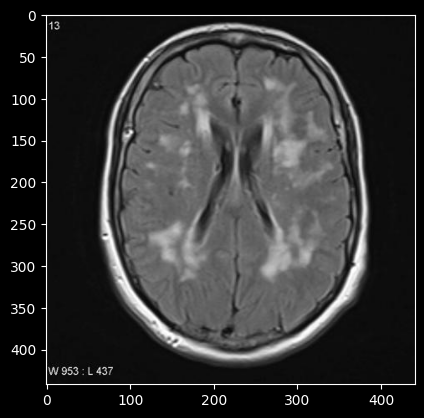

In [17]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/Modelli_della_Percezione/Dataset/brain_tumor_dataset/no/44no.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

99.99878406524658% Confidence This Is A Its a Tumor


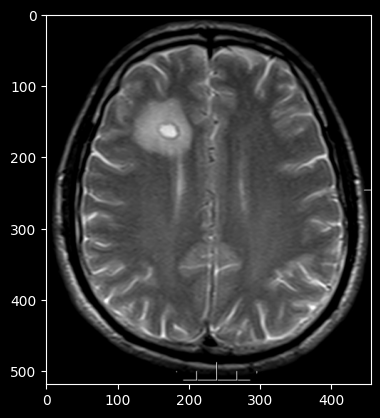

In [18]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/Modelli_della_Percezione/Dataset/brain_tumor_dataset/yes/Y3.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is A ' + names(classification))